# Sentiment Analysis using DistilBERT

### Importing libraries

In [5]:
import os
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import DistilBertModel, DistilBertTokenizer
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Reading the csv file

In [6]:
data_file_path = '/kaggle/input/amazon/test.csv'
df_original = pd.read_csv(data_file_path)

## Data Exploration

In [7]:

# Splitting the data into 2
df, df_2 = train_test_split(df_original, test_size=0.5, random_state=42)


### Viewing the number of reviews in the train set

In [8]:
print(len(df))

199999


In [9]:
# # Missing Values Heatmap
# import missingno as msno

# msno.heatmap(df)
# plt.title('Missing Values Heatmap')
# plt.show()

### Viewing the first 5 entries

In [10]:
df.head()

,2,Great CD,"My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing ""Who was that singing ?"""
387723,1,I really tried to like it----,"But my impressions was....yeck. Thin plot, thi..."
153308,1,Please do NOT purchase from this company.,[[ASIN:B0007KQZWU Cuisinart MCP-12 MultiClad P...
379690,1,too theoretical,I bought this thinking it would help me unders...
194003,1,As I Expected...,"If you like clichéd electronic pop, you will l..."
230929,2,Are you a Butterfly?,This is a book i would recommend to all of the...


In [11]:
# Define a function to map sentiment values
def map_values(value):
    if value == 1:
        return "negative"
    elif value == 2:
        return "positive"

new_column_names={'2':'Sentiment number','Great CD':'Description','My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"':'Text Review'}
df.rename(columns=new_column_names, inplace=True)

# Apply the mapping function to create a 'sentiment' column
df['sentiment'] = df['Sentiment number'].apply(map_values)

In [12]:
df['Sentiment number'] = df['Sentiment number'] - 1  # Adjust labels to 0 and 1

### Printing the column names

In [13]:
df.columns

Index(['Sentiment number', 'Description', 'Text Review', 'sentiment'], dtype='object')

In [14]:
# Checking the number of rows and columns
df.shape

(199999, 4)

### Printing the first 5 examples of the updated dataset

In [15]:
df.head()

,Sentiment number,Description,Text Review,sentiment
387723,0,I really tried to like it----,"But my impressions was....yeck. Thin plot, thi...",negative
153308,0,Please do NOT purchase from this company.,[[ASIN:B0007KQZWU Cuisinart MCP-12 MultiClad P...,negative
379690,0,too theoretical,I bought this thinking it would help me unders...,negative
194003,0,As I Expected...,"If you like clichéd electronic pop, you will l...",negative
230929,1,Are you a Butterfly?,This is a book i would recommend to all of the...,positive


In [16]:
print(df['sentiment'].value_counts())

sentiment
positive    100076
negative     99923
Name: count, dtype: int64


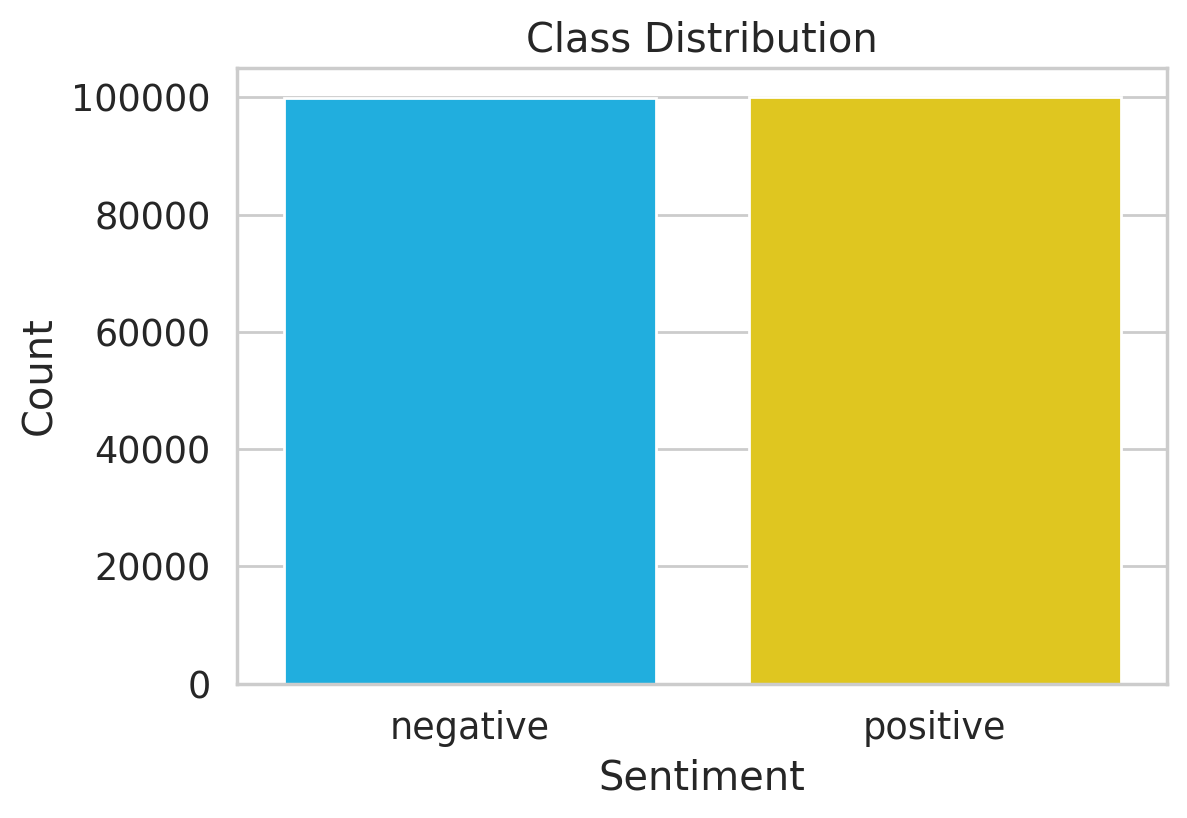

In [17]:
# Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df['sentiment'])
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [18]:
print("\nStatistical Summary of Numeric Columns:")
print(df.describe())


Statistical Summary of Numeric Columns:
       Sentiment number
count     199999.000000
mean           0.500383
std            0.500001
min            0.000000
25%            0.000000
50%            1.000000
75%            1.000000
max            1.000000


In [19]:
# Text Data Analysis (Basic)
df['review_length'] = df['Text Review'].apply(len)
print("\nReview Length Descriptive Statistics:")
print(df['review_length'].describe())


Review Length Descriptive Statistics:
count    199999.000000
mean        404.351142
std         233.916343
min          15.000000
25%         207.000000
50%         355.000000
75%         564.000000
max        1009.000000
Name: review_length, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


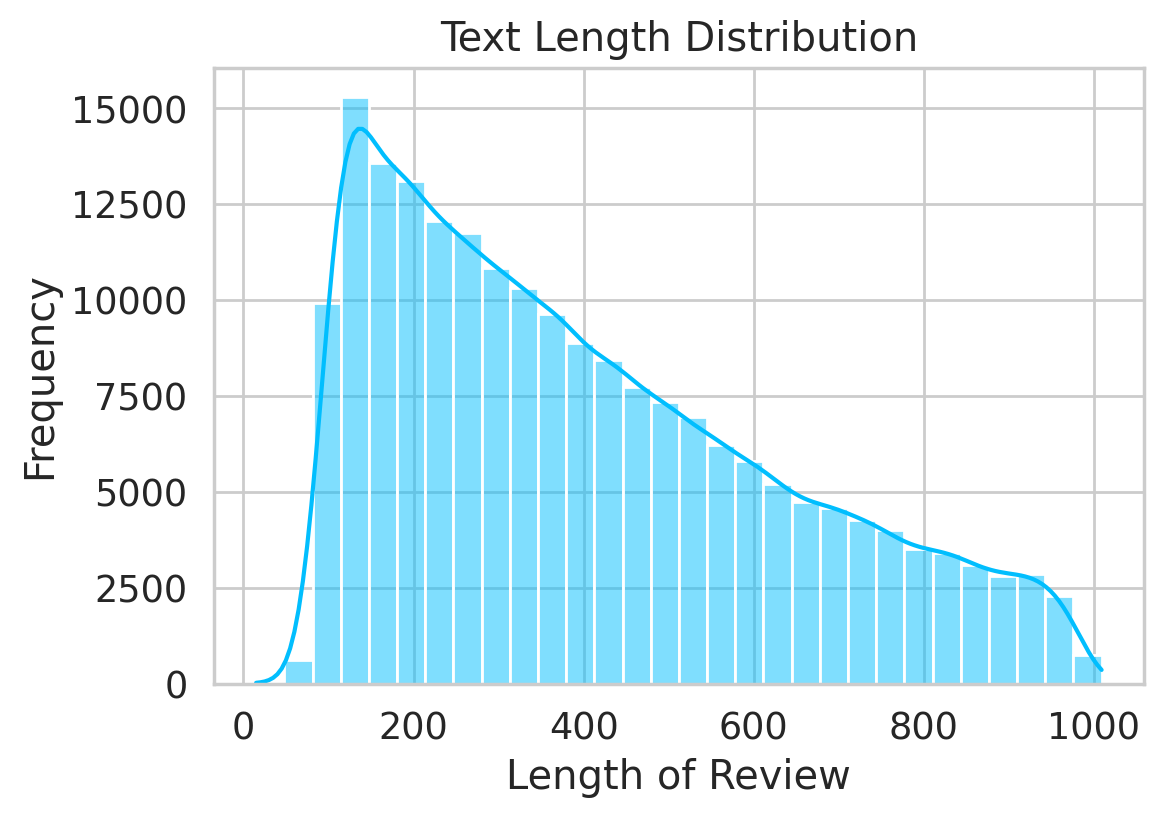

In [20]:
# Text Length Distribution
plt.figure(figsize=(6,4))
sns.histplot(df['review_length'], bins=30, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Length of Review')
plt.ylabel('Frequency')
plt.show()

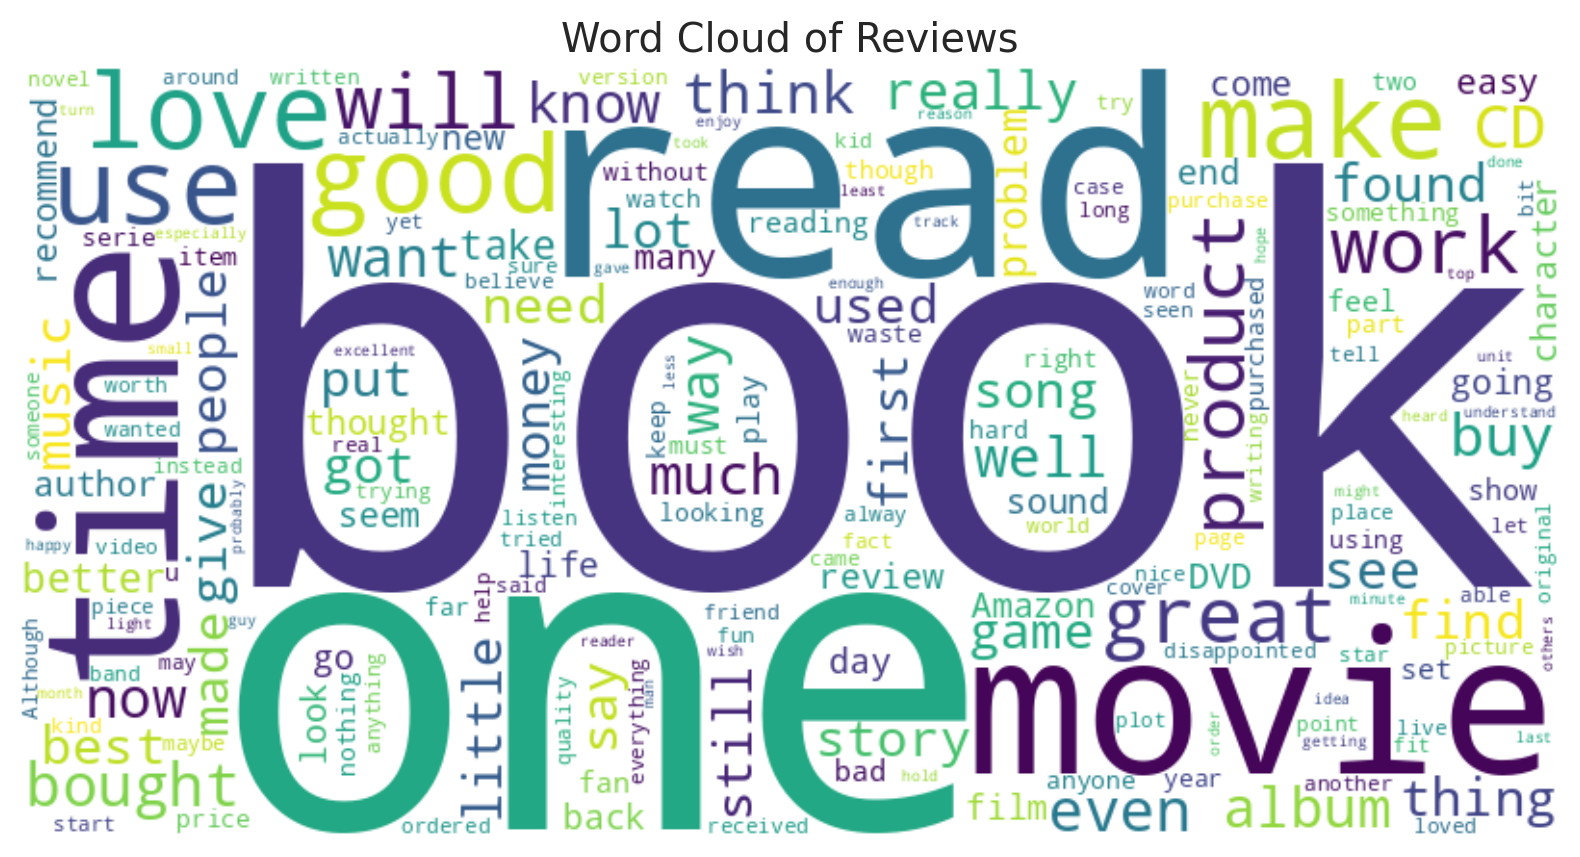

In [21]:
# Word Cloud
from wordcloud import WordCloud

text = " ".join(review for review in df['Text Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

## Data Preprocessing

### Load a pre-trained DistilBertTokenizer

In [22]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'

In [23]:
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

### Special Tokens

In [24]:
#[SEP] - marker for ending of a sentence
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [25]:
#[CLS] - adding at the start of each sentence for BERT to know we're doing classificatio
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [26]:
#[PAD] - for padding
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [27]:
# tokens not in the dataset can be encoded using [UNK] (unknown) token
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

### Choosing Sequence Length

In [28]:
MAX_LEN = 256

In [29]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          truncation=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

### Data splitting

In [30]:
# Define the split ratios
test_split = 0.15
val_split = 0.15  # 15% of the remaining data after test split

# Split the data into (Train + Validation) and Test
df_train_val, df_test = train_test_split(df, test_size=test_split, random_state=RANDOM_SEED)

# Split the remaining data into Train and Validation
df_train, df_val = train_test_split(df_train_val, test_size=val_split, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape


((144499, 5), (25500, 5), (30000, 5))

## Data Loader

### Creating data loaders. Below is the helper function

In [31]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df['Text Review'].to_numpy(),
        targets=df['Sentiment number'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [32]:
# Example batch from the training data loader

data = next(iter(train_data_loader))
data.keys()


print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


## Model Initialization

## Sentiment Classification with DistilBERT and Hugging Face

In [33]:
# Load the model

distilbert_model = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

### Classifier that uses DistilBERT model

In [34]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.distilbert.config.dim, n_classes)

    def forward(self, input_ids, attention_mask):
        output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output[0]  # Output is a tuple (hidden_state, attention)
        pooled_output = hidden_state[:, 0]  # Take the first token ([CLS]) for classification
        output = self.drop(pooled_output)
        return self.out(output)


In [35]:
#Creating an instance and moving to GPU
model = SentimentClassifier(2)
model = model.to(device)

## Evaluation on Pre-trained model before fine-tuning

In [36]:
loss_fn = nn.CrossEntropyLoss().to(device)

In [37]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [38]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [39]:
print("Evaluating the pre-trained model on the test set before fine-tuning...")
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)
print(f'Test Accuracy (Pre-Fine-tuning): {test_acc.item()}')

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

# Classification report and confusion matrix
class_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=class_names))

Evaluating the pre-trained model on the test set before fine-tuning...


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Test Accuracy (Pre-Fine-tuning): 0.5019333333333333


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

              precision    recall  f1-score   support

    negative       0.69      0.00      0.00     14948
    positive       0.50      1.00      0.67     15052

    accuracy                           0.50     30000
   macro avg       0.59      0.50      0.33     30000
weighted avg       0.59      0.50      0.34     30000



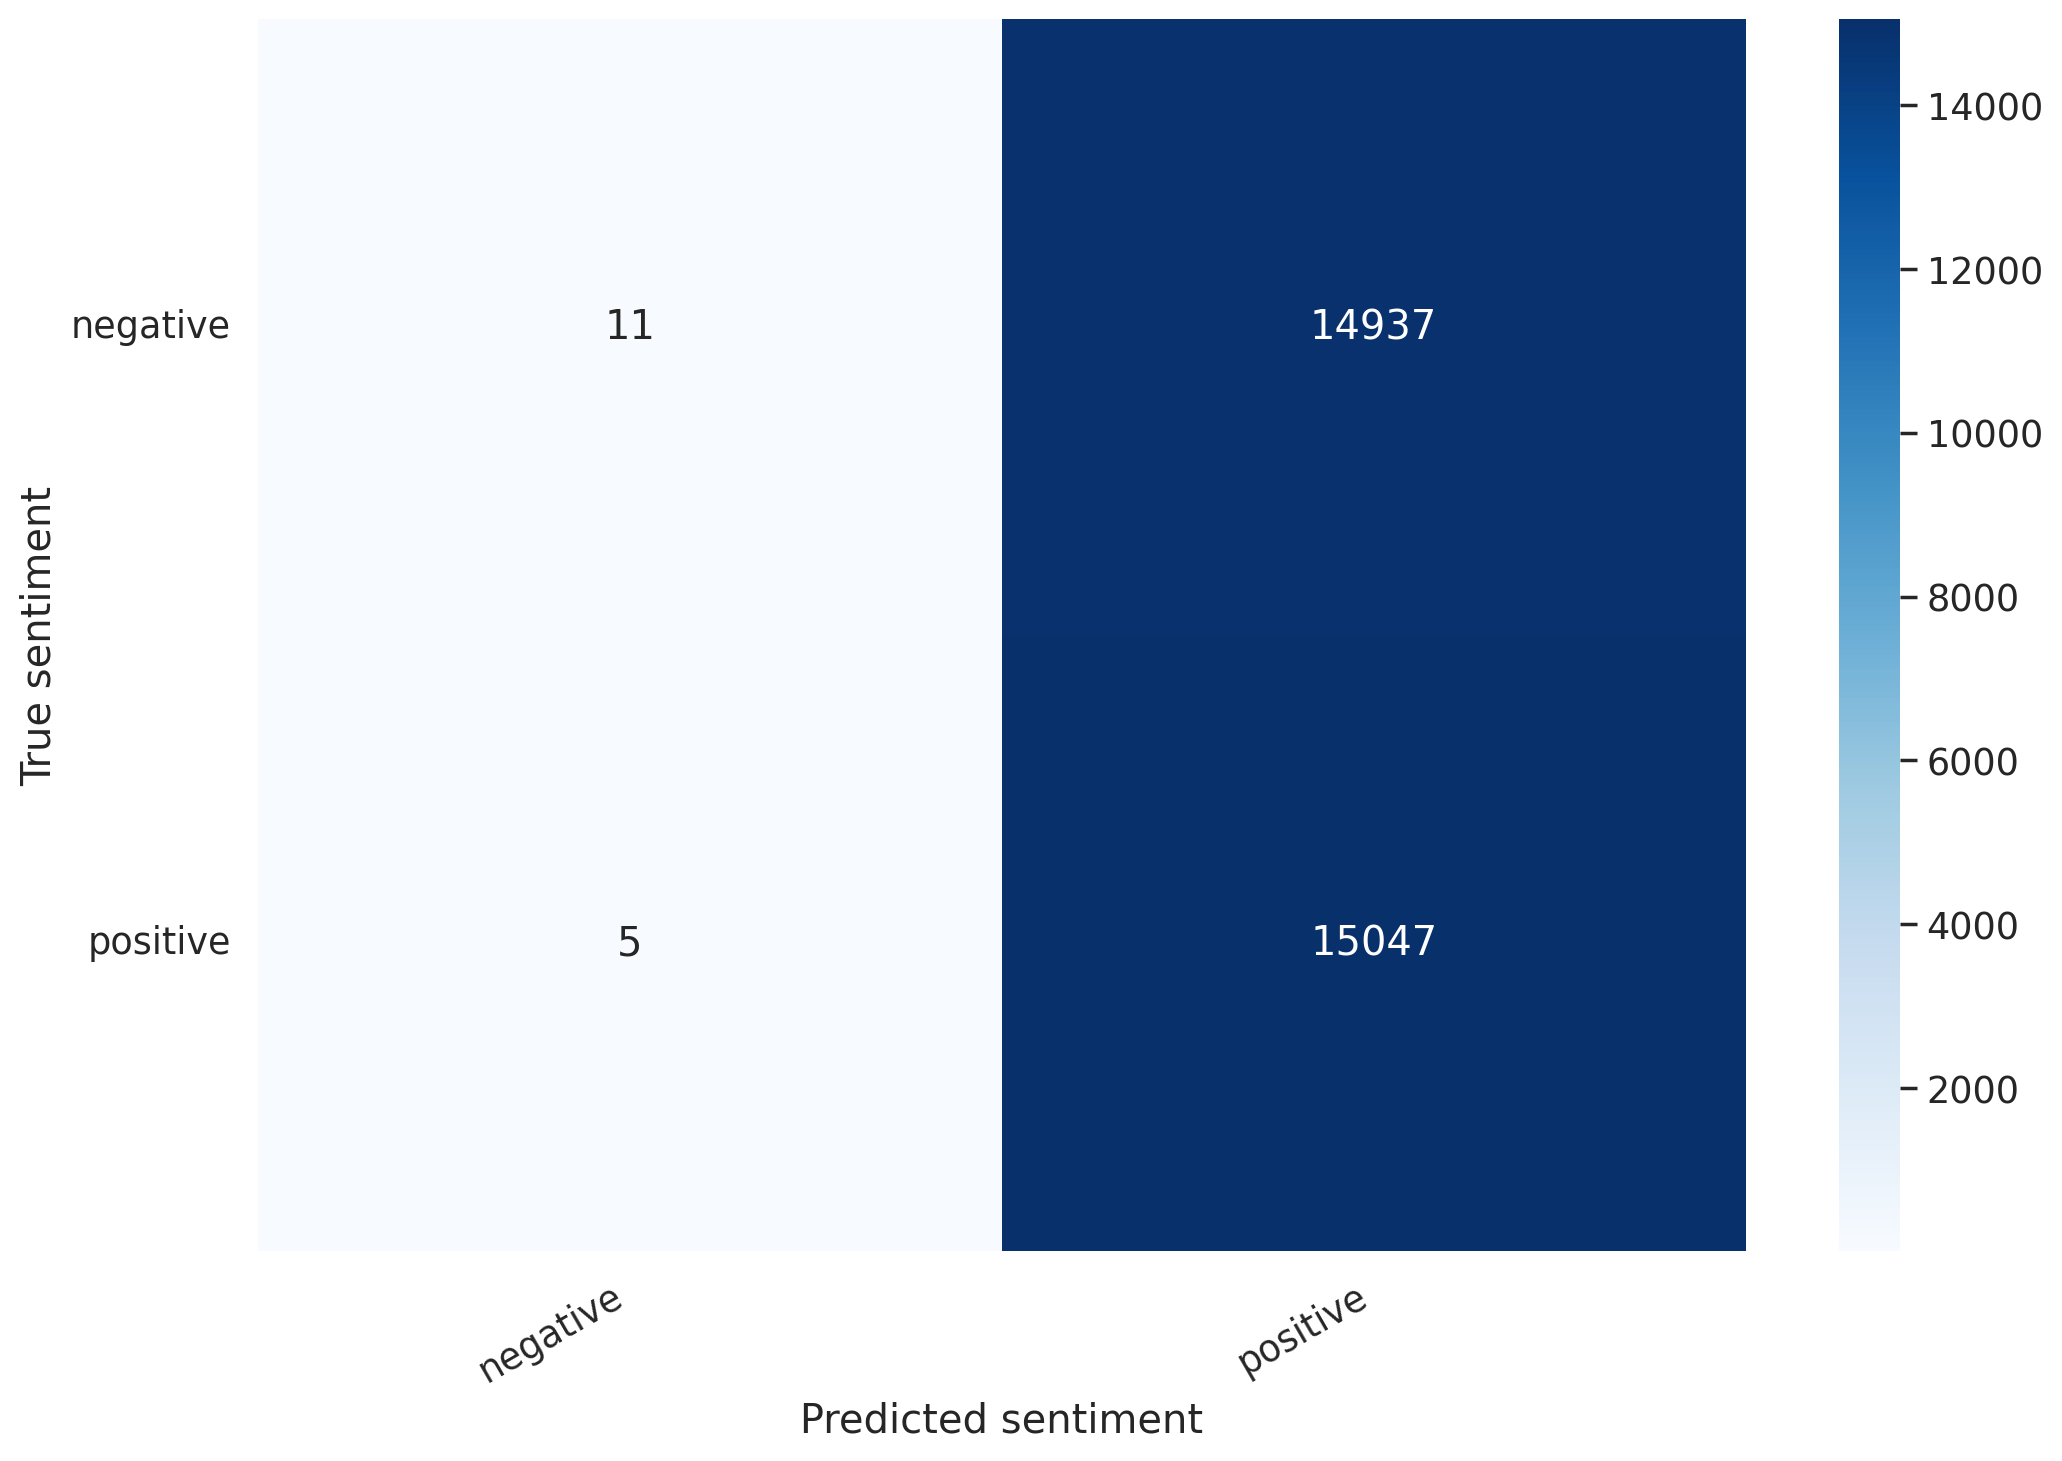

In [40]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [41]:
review_text = "Your services are good. Well done!"

In [42]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [43]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
probabilities = F.softmax(output, dim=1) #Apply softmax to calculate probabilities
_, prediction = torch.max(probabilities, dim=1)
confidence = probabilities[0, prediction.item()].item()
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')
print(f'Confidence : {confidence * 100:.2f}%')

Review text: Your services are good. Well done!
Sentiment  : positive
Confidence : 56.84%


## Fine-tuning Process

In [58]:
# Move example batch for the training data to GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 256])
torch.Size([16, 256])


In [59]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.8064, 0.1936],
        [0.5737, 0.4263],
        [0.5733, 0.4267],
        [0.1370, 0.8630],
        [0.3598, 0.6402],
        [0.2949, 0.7051],
        [0.7781, 0.2219],
        [0.2783, 0.7217],
        [0.2533, 0.7467],
        [0.5846, 0.4154],
        [0.7242, 0.2758],
        [0.6612, 0.3388],
        [0.5717, 0.4283],
        [0.2134, 0.7866],
        [0.9030, 0.0970],
        [0.2080, 0.7920]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Training

In [60]:
# Freeze all the parameters in DistilBertModel
for param in model.distilbert.parameters():
    param.requires_grad = False

# Only the parameters in the classification layer will be fine-tuned
optimizer = AdamW(model.out.parameters(), lr=3e-5, correct_bias=False)


In [61]:
EPOCHS = 3
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

### Helper function for training our model for one epoch

In [62]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [63]:
from tqdm import tqdm

def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
    ):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in tqdm(data_loader, desc='Training', leave=False):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

### Training loop

In [64]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/3
----------


Training:   0%|          | 0/9032 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

Train loss 0.40949595095037067 accuracy 0.8269538197496177


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.3672454205190896 accuracy 0.8486274509803922

Epoch 2/3
----------


Training:   0%|          | 0/9032 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

Train loss 0.3858930605114747 accuracy 0.8341372604654704


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.3551007039620631 accuracy 0.8523137254901961

Epoch 3/3
----------


Training:   0%|          | 0/9032 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

Train loss 0.3804394565935125 accuracy 0.8352929778060748


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.3522313518480046 accuracy 0.8525490196078431

CPU times: user 34min 49s, sys: 27.1 s, total: 35min 16s
Wall time: 35min 33s


### Plotting the training and validation accuracy

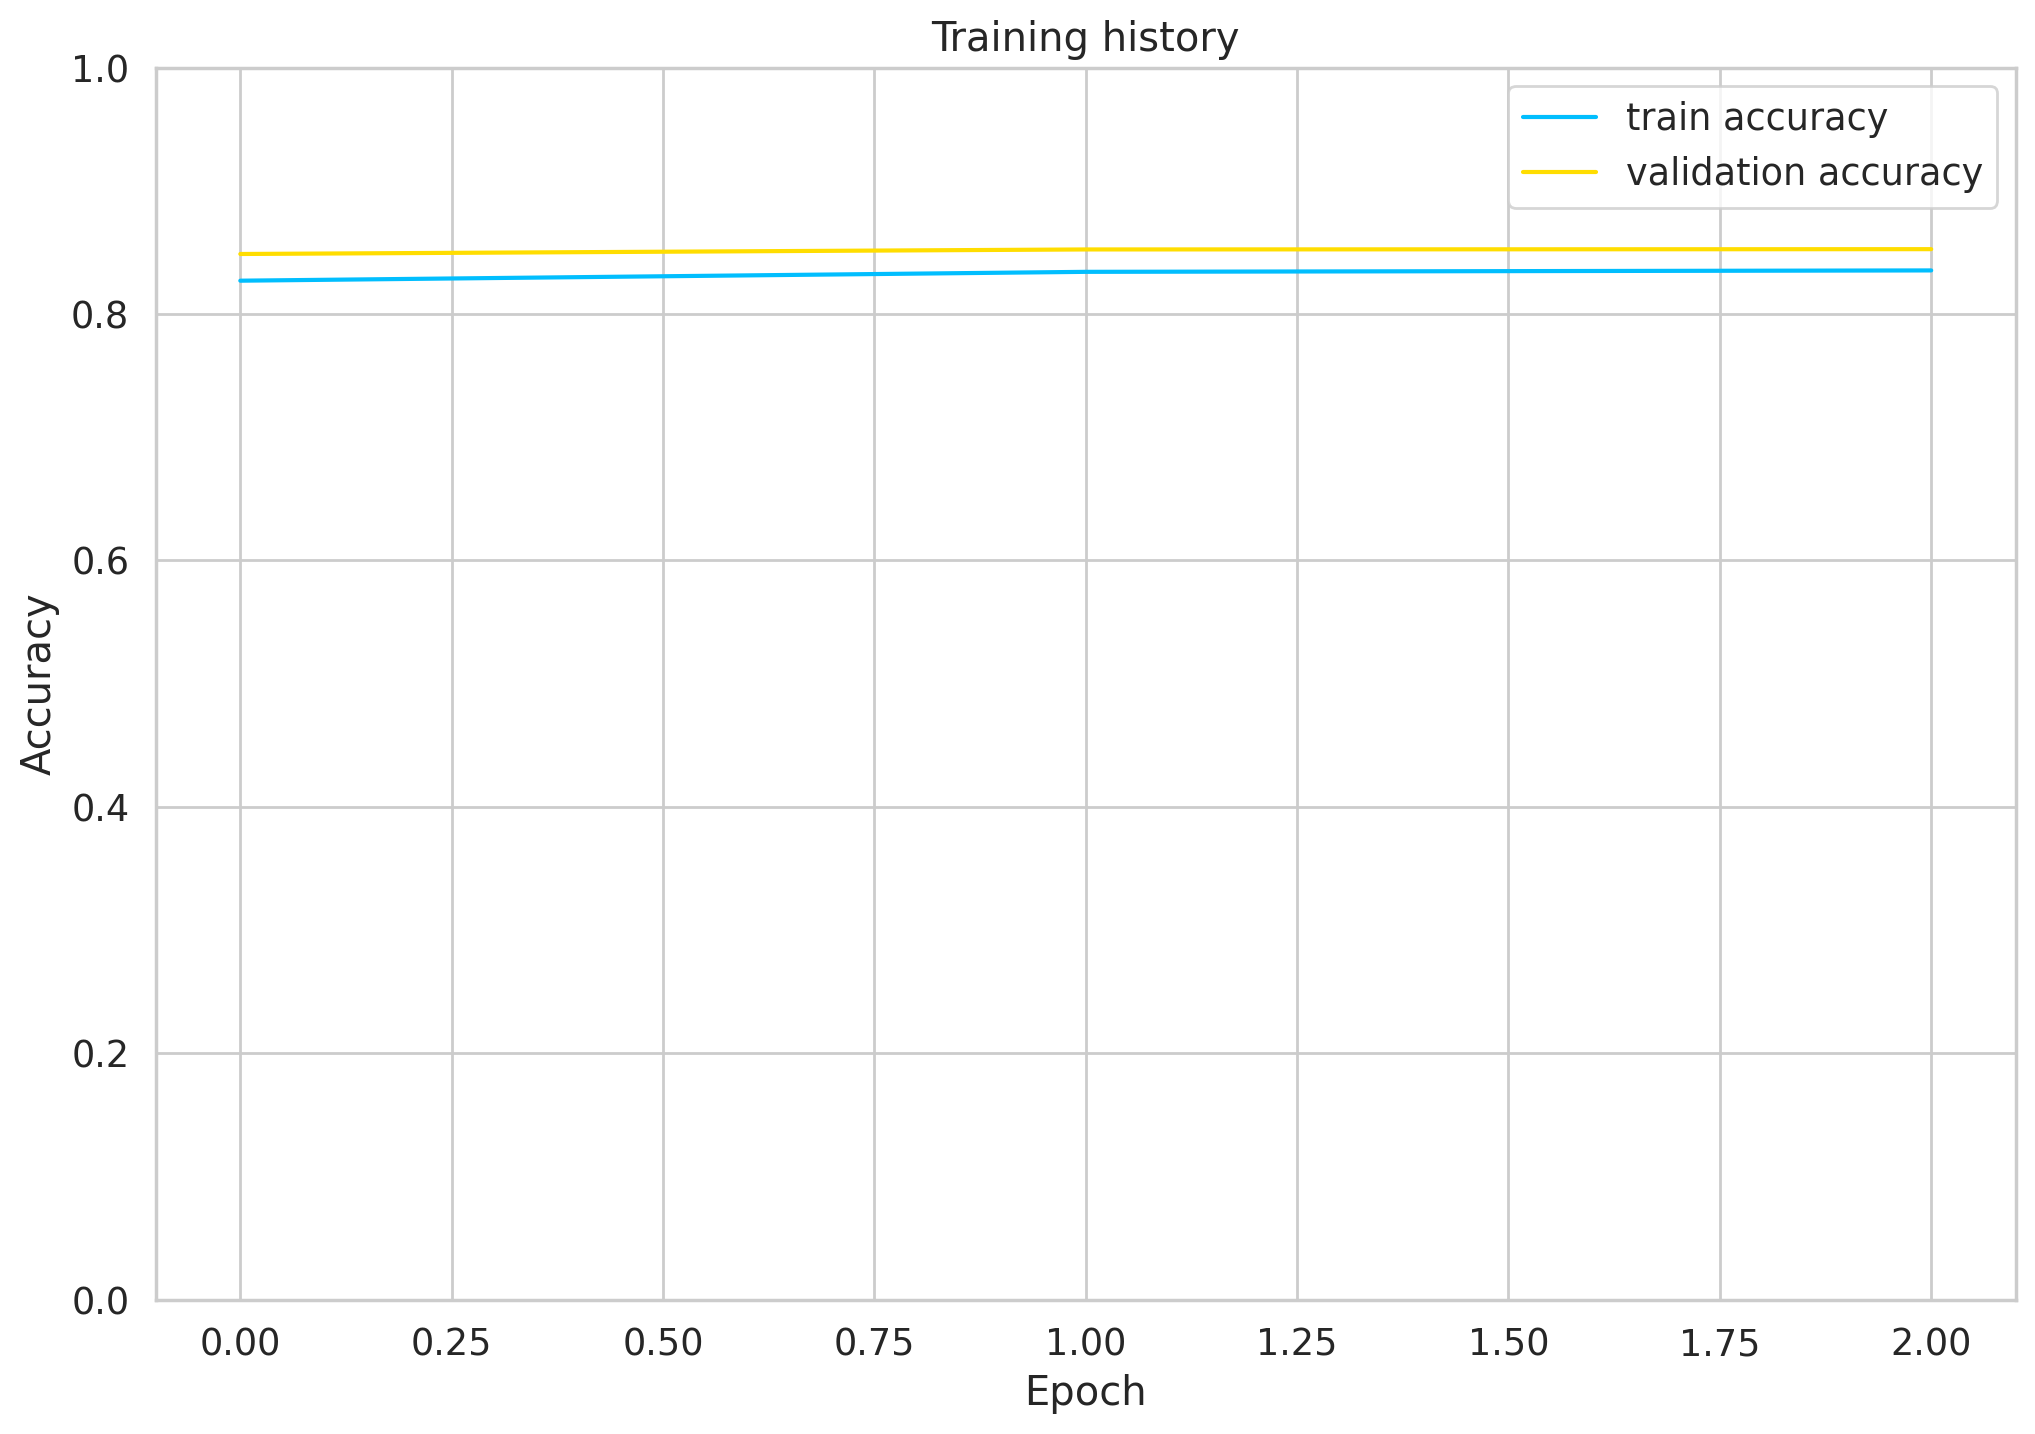

In [65]:
# Convert each value in the lists to CPU-based if they are CUDA tensors
train_acc = [x.cpu().item() if torch.is_tensor(x) and x.is_cuda else x for x in history['train_acc']]
val_acc = [x.cpu().item() if torch.is_tensor(x) and x.is_cuda else x for x in history['val_acc']]

# Now plot
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()




## Evaluation of finetuned model

In [66]:
# Save the model state
model_save_path = 'sentiment_classifier_model.pth'
torch.save(model.state_dict(), model_save_path)


In [67]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print(f'Test Accuracy (Post-Fine-tuning): {test_acc.item()}')
#test_acc.item()

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Test Accuracy (Post-Fine-tuning): 0.8515


In [68]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

### Classification report

In [69]:
class_names = ['negative', 'positive']

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.83      0.88      0.85     14948
    positive       0.87      0.83      0.85     15052

    accuracy                           0.85     30000
   macro avg       0.85      0.85      0.85     30000
weighted avg       0.85      0.85      0.85     30000



### Confusion matrix

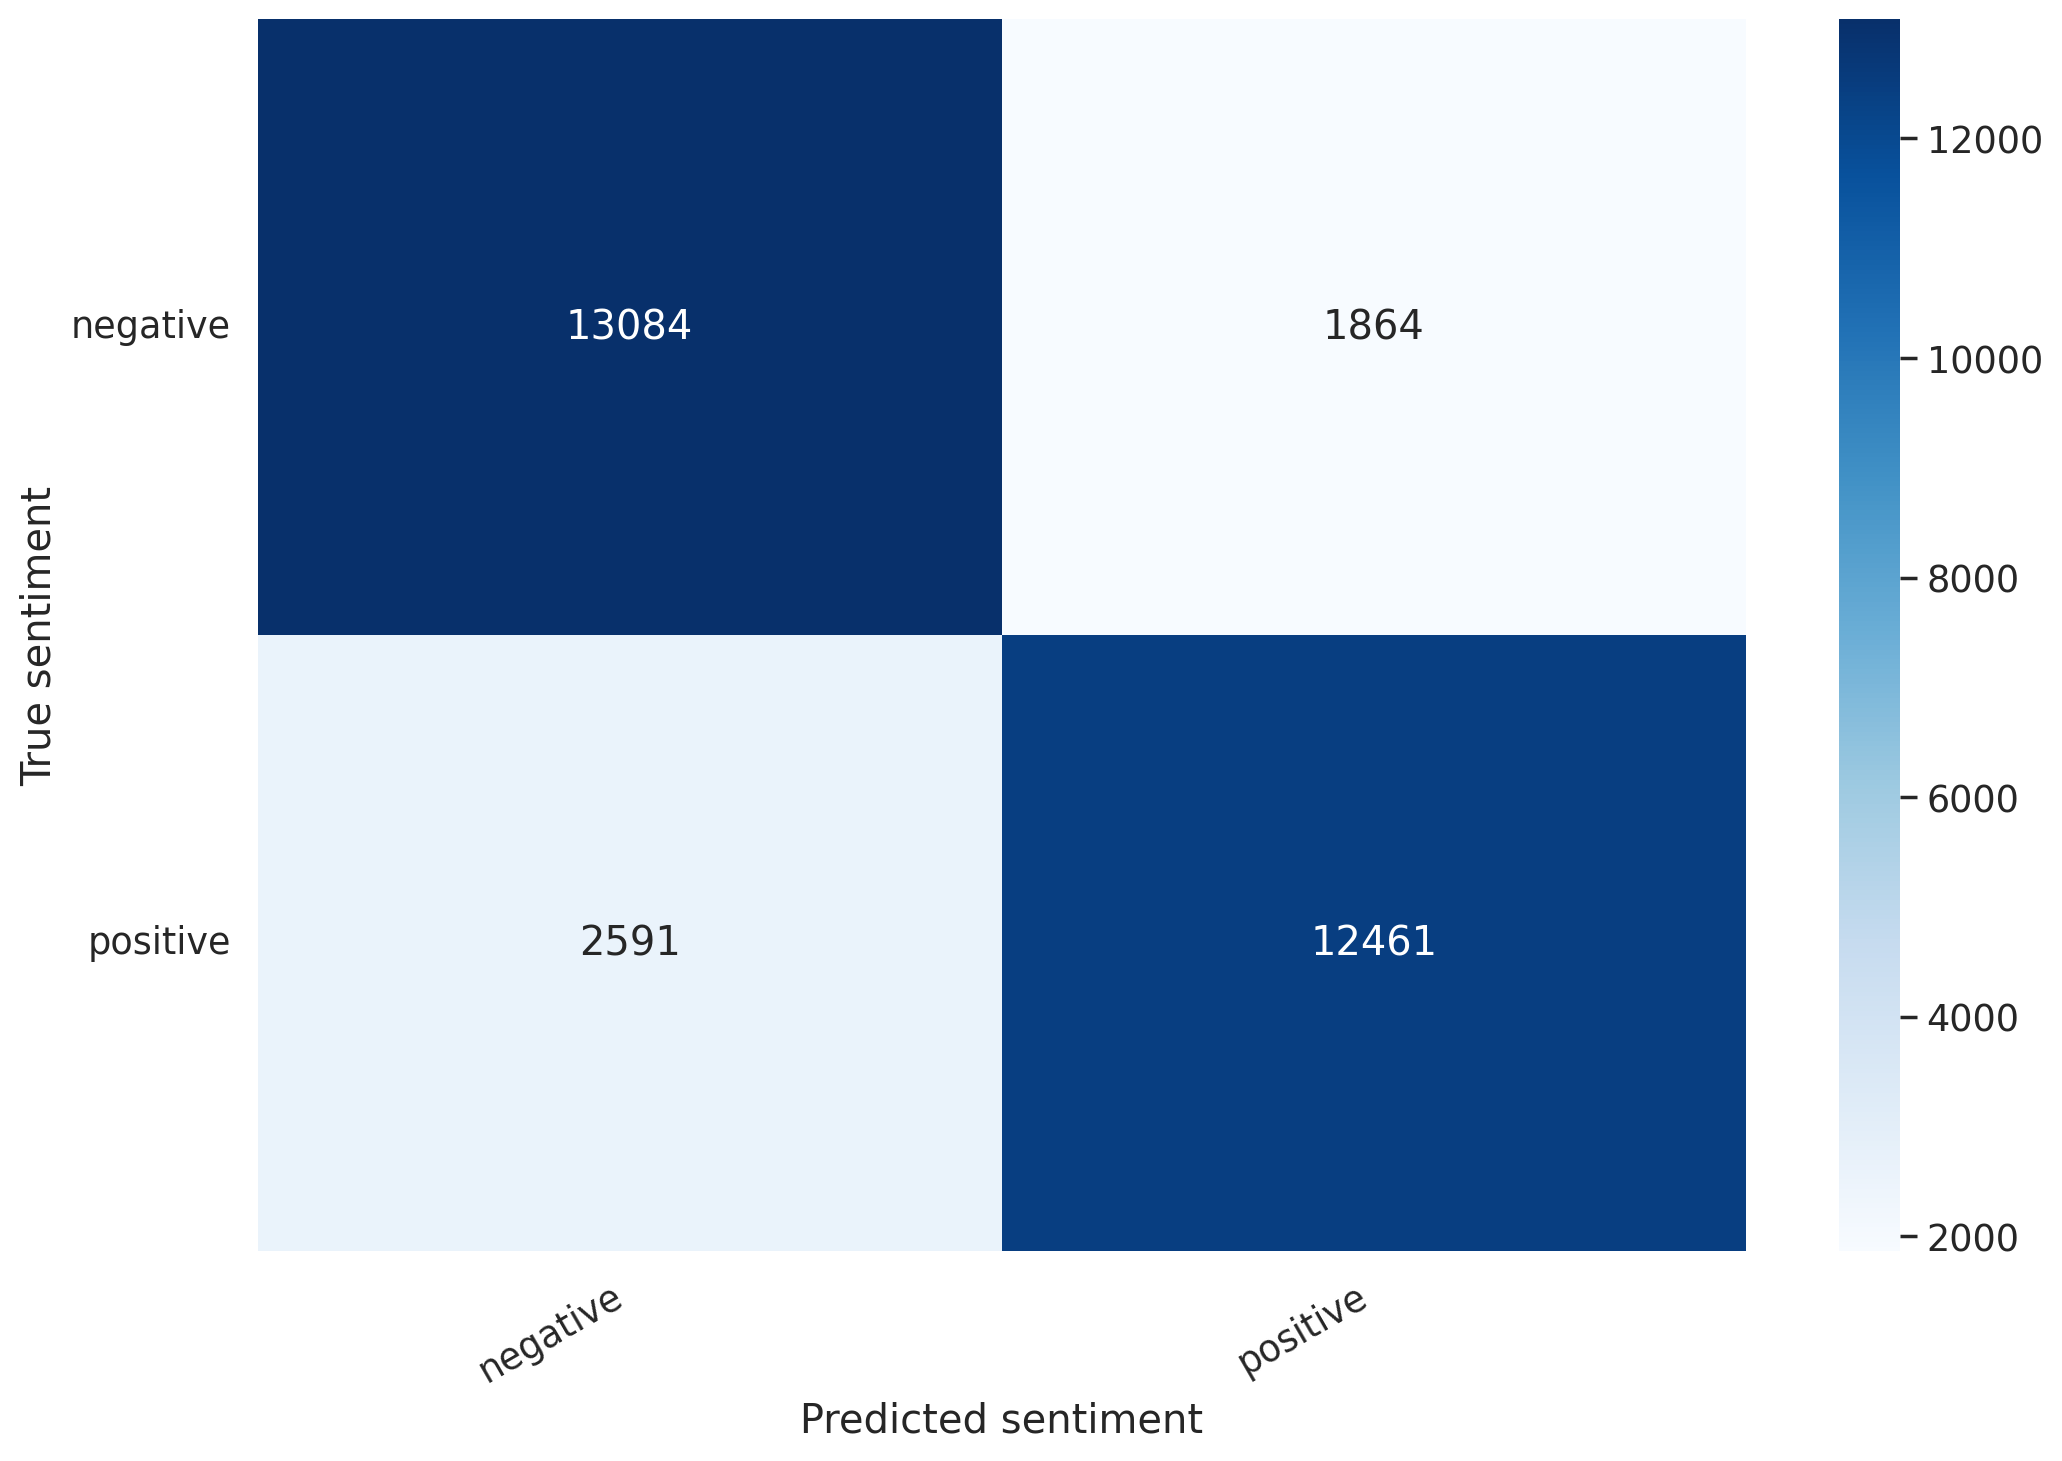

In [70]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Predicting on Raw Text

In [71]:
review_text = "I got my fries very late from your shop. I am very sad. You should improve your services."

### Tokenize to encode the text

In [72]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Get predictions from the model

In [73]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
probabilities = F.softmax(output, dim=1) #Apply softmax to calculate probabilities
_, prediction = torch.max(probabilities, dim=1)
confidence = probabilities[0, prediction.item()].item()
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')
print(f'Confidence : {confidence * 100:.2f}%')

Review text: I got my fries very late from your shop. I am very sad. You should improve your services.
Sentiment  : negative
Confidence : 55.91%
